In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
products = pd.read_csv('./amazon_baby_subset.csv')
important_words = pd.read_json('./important_words.json', typ=list)

products = products.fillna({'review':''})

In [11]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation)

products['review_clean'] = products['review'].apply(remove_punctuation)
products = products.drop('review', axis=1)

In [12]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [15]:
train_idx = pd.read_json('./module-10-assignment-train-idx.json', typ=list)
validation_idx = pd.read_json('./module-10-assignment-validation-idx.json', typ=list)

train_data = products.iloc[train_idx]
validation_data = products.iloc[validation_idx]

In [18]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

In [20]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, list(important_words), 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, list(important_words), 'sentiment')

/home/jue/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Q1

In [22]:
print 'it won\'t change the number of features used'

it won't change the number of features used


# Building on logistic regression

In [23]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1./(1. + np.exp(-score))
    
    # return predictions
    return predictions

# Derivative of log likelihood with respect to a single coefficient

In [24]:
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)
    # Return the derivative
    return derivative

In [25]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)   
    
    return lp

## Q2

In [26]:
print 'the latter one is scaled down by a factor of N'

the latter one is scaled down by a factor of N


# Modify derivative for stochastic ascent

In [27]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print "Gradient single data point: %s" % gradient_single_data_point
print "           --> Should print 0.0"

Gradient single data point: 0.0
           --> Should print 0.0


## Q3

In [28]:
print 'No, it is a scalar'

No, it is a scalar


# Modify derivative for using a batch of data points

In [29]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print "Gradient mini-batch data points: %s" % gradient_mini_batch
print "                --> Should print 1.0"

Gradient mini-batch data points: 1.0
                --> Should print 1.0


## Q4 and Q5

In [30]:
print 'it is a scalar'
print 'when B = N'

it is a scalar
when B = N


# Averaging the gradient across a batch

# Implement stochastic gradient ascent

In [75]:
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []

    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]

    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions = predict_probability(feature_matrix[i:i+batch_size, :], coefficients)

        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        ### YOUR CODE HERE
        indicator = (sentiment[i:i+batch_size] == +1)

        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            ### YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size, j])
                  # Compute the product of the step size, the derivative, and
            # the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
            coefficients[j] += (1./batch_size) * derivative * step_size

        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print 'Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp)  

        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0                

    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

# Q6

In [76]:
print 'batch_size = N'

batch_size = N


# Run gradient ascent using stochastic gradient ascent implementation

In [77]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = 1
max_iter = 10

[stochastic_coefficients, stochastic_log_likelihood_all] = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                                                                 initial_coefficients, step_size, batch_size,
                                                                                 max_iter)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.00000124


## Q7

In [78]:
print 'the average likelihood fluctuates'

the average likelihood fluctuates


In [79]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = feature_matrix_train.shape[0]
max_iter = 200

[grad_coefficients, grad_log_likelihood_all] = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                                                                 initial_coefficients, step_size, batch_size,
                                                                                 max_iter)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

In [80]:
print 'the average log likelihood increases'

the average log likelihood increases


# Make 'Passes' over dataset

In [81]:
print 50000*2/100

1000


# Log likelihood plots for stochastic gradient ascent

In [82]:
step_size=1e-1
batch_size=100
initial_coefficients = np.zeros(194)
max_iter = 10*feature_matrix_train.shape[0]/batch_size

[batch_coefficients, batch_log_likelihood_all] = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                                                                 initial_coefficients, step_size, batch_size,
                                                                                 max_iter)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration   11: Average log likelihood (of data points  [01100:01

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

# Stochastic gradient ascent vs batch gradient ascent

In [84]:
step_size = 1e-1
batch_size = 100
initial_coefficients = np.zeros(194)
num_pass = 200
max_iter = num_pass * feature_matrix_train.shape[0]/batch_size

[stochastic_coefficients, stochastic_log_likelihood_all] = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                                                                 initial_coefficients, step_size, batch_size,
                                                                                 max_iter)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

In [85]:
step_size = 0.5
batch_size = feature_matrix_train.shape[0]
initial_coefficients = np.zeros(194)
max_iter = 200

[batch_coefficients, batch_log_likelihood_all] = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                                                                 initial_coefficients, step_size, batch_size,
                                                                                 max_iter) 

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

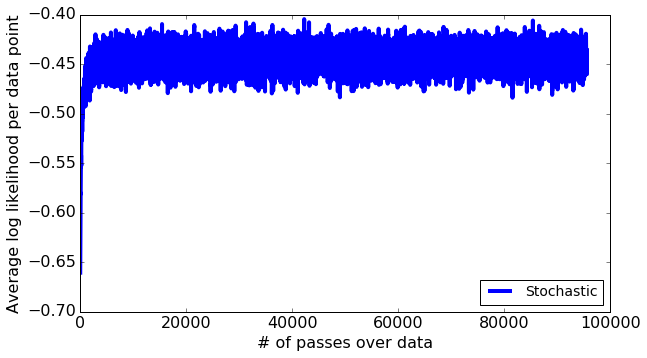

In [87]:
make_plot(stochastic_log_likelihood_all, feature_matrix_train.shape[0], batch_size, smoothing_window=30, label='Stochastic')

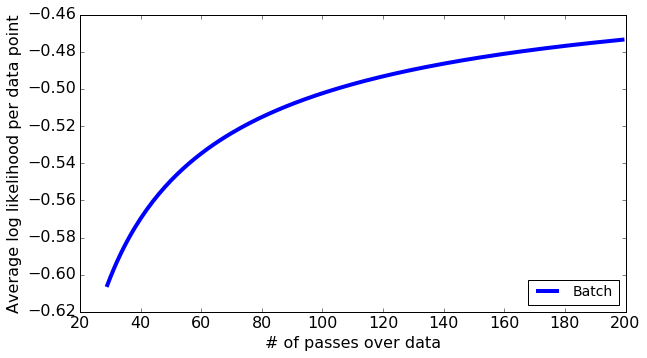

In [88]:
make_plot(batch_log_likelihood_all, feature_matrix_train.shape[0], batch_size, smoothing_window=30, label='Batch')

## Q8

In [47]:
print 'Batch needs around 180 passes to achieve similar log likelihood as stochastic'

Batch needs around 180 passes to achieve similar log likelihood as stochastic


# Explore the effects of step sizes on stochastic gradient ascent

In [89]:
step_size = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
batch_size = 100
initial_coefficients = np.zeros(194)
num_pass = 10
max_iter = 10*feature_matrix_train.shape[0]/batch_size

my_coefficients = []
my_log_likelihood_all = []
for step in step_size:
    print step
    coeff, ll = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                         initial_coefficients, step, batch_size, max_iter)
    my_coefficients.append(coeff)
    my_log_likelihood_all.append(ll)


0.0001
Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69311286
Iteration   11: Average log likelihood (of data points  [0

In [90]:
smoothing_window = 30

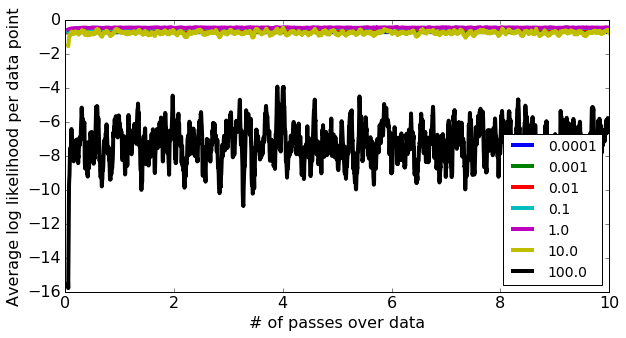

In [91]:
for i in range(len(step_size)):
    make_plot(my_log_likelihood_all[i], feature_matrix_train.shape[0], batch_size, smoothing_window=30, label=str(step_size[i]))

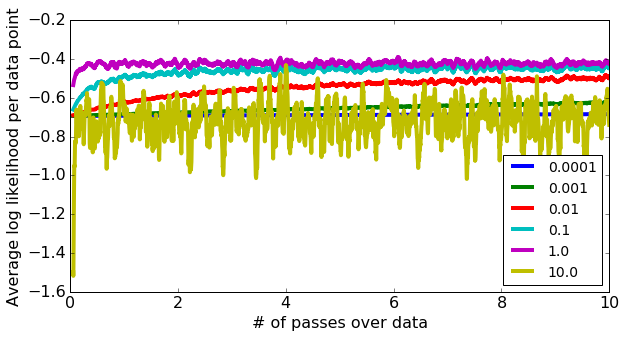

In [92]:
for i in range(len(step_size)-1):
    make_plot(my_log_likelihood_all[i], feature_matrix_train.shape[0], batch_size, smoothing_window=30, label=str(step_size[i]))

In [93]:
feature_matrix_train.shape

(47780, 194)